# Visual Question Answering (VQA) Analysis with BLIP-2

This notebook implements a VQA system using the BLIP-2 model, evaluates its performance on a dataset, and provides detailed metrics and error analysis. The code processes images and questions, generates answers, and computes metrics such as Exact Match, Token Match, Wu-Palmer (WUP) Score, F1 Score, and BERTScore.

---

## Setup and Dependencies

The following steps outline the initial setup:

- **Import libraries**  
  Includes `torch`, `transformers`, `PIL`, `pandas`, `nltk`, `sklearn`, and `accelerate` for model processing and evaluation.

- **Define file paths**  
  Specifies locations for images, VQA dataset, metadata, and output files.

- **Download NLTK resources**  
  Ensures WordNet, Punkt, and POS tagger are available for text processing.

- **Suppress warnings and clear GPU memory**  
  Improves output clarity and manages resources.


In [ ]:
import os
import json
import csv
import torch
import numpy as np
from PIL import Image
from transformers import Blip2Processor, Blip2ForConditionalGeneration, BertTokenizer, BertModel, Blip2Config
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score
import nltk
from nltk.corpus import wordnet as wn
from collections import Counter
import re

from accelerate import infer_auto_device_map, init_empty_weights

import warnings
warnings.filterwarnings("ignore")
torch.cuda.empty_cache()



# Define paths
IMAGE_BASE_DIR = r"/kaggle/input/vr-project-images/images/small"
VQA_DATA_FILE = "/kaggle/input/vr-project-json/testing.json"
# VQA_DATA_FILE = "/kaggle/input/vr-project-temp-json/temp.json"
INPUT_IMAGES_FILE = "/kaggle/input/vr-project-images/images/metadata/images.csv"
OUTPUT_RESULTS_FILE = "/kaggle/working/vqa_results.csv"
OUTPUT_METRICS_FILE = "/kaggle/working/vqa_metrics.json"

# Make sure necessary NLTK packages are downloaded
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

## Data Loading Functions

These functions load the necessary data for VQA processing:

- **`load_image_metadata`**  
  Reads image metadata from a CSV file into a dictionary mapping image IDs to their properties (height, width, path).

- **`load_vqa_data`**  
  Loads the VQA dataset from a JSON file containing image IDs and associated questions/answers.


In [ ]:
def load_image_metadata():
    """Load image metadata from CSV into a dictionary."""
    image_map = {}
    with open(INPUT_IMAGES_FILE, "r", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            image_map[row["image_id"]] = {
                "height": int(row["height"]),
                "width": int(row["width"]),
                "path": row["path"]
            }
    return image_map

def load_vqa_data():
    """Load the VQA dataset from JSON."""
    with open(VQA_DATA_FILE, "r", encoding="utf-8") as f:
        vqa_data = json.load(f)
    return vqa_data

## Model Initialization

The following functions set up the models used in the pipeline:

- **`setup_vqa_model`**  
  Initializes the BLIP-2 model (`Salesforce/blip2-opt-2.7b`) and processor, using float16 precision and moving to GPU if available.

- **`setup_bertscore_model`**  
  Sets up the BERT tokenizer and model (`bert-base-uncased`) for BERTScore calculation, also moving to GPU if available.


In [ ]:
def setup_vqa_model():
    """Initialize the BLIP-2 model for VQA tasks."""
    # Using BLIP-2 instead of BLIP
    processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
    model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b",torch_dtype=torch.float16).to("cuda")
    
    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    return processor, model, device

def setup_bertscore_model():
    """Initialize models for BERTScore calculation."""
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    return tokenizer, model, device

## Text Normalization and Scoring Functions

These functions handle text processing and metric calculations:

- **`normalize_answer`**  
  Normalizes answers by converting digits to words, removing articles, punctuation, and extra whitespace.

- **`calculate_bertscore`**  
  Computes BERTScore using BERT embeddings and cosine similarity.

- **`exact_match`**  
  Checks if the predicted answer exactly matches the ground truth after normalization.

- **`token_match`**  
  Compares token sets between predicted and ground truth answers.

- **`get_wordnet_pos`**  
  Maps NLTK POS tags to WordNet POS for WUP similarity.

- **`calculate_wup_score`**  
  Calculates Wu-Palmer similarity between predicted and ground truth answers.

- **`calculate_f1_score`**  
  Computes F1 score based on token overlap.


In [ ]:
def normalize_answer(s):
    """Normalize answer for more accurate comparison."""
    # Define reversed number map (digits to words)
    number_map = {
        '0': 'zero', '1': 'one', '2': 'two', '3': 'three', '4': 'four',
        '5': 'five', '6': 'six', '7': 'seven', '8': 'eight', '9': 'nine', '10': 'ten'
    }
    
    # Convert digits to words
    for digit, word in number_map.items():
        s = re.sub(r'\b' + digit + r'\b', word, s.lower())
    
    # Remove articles
    s = re.sub(r'\b(a|an|the)\b', ' ', s)
    # Remove punctuation and extra whitespace
    s = re.sub(r'[^\w\s]', '', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

def calculate_bertscore(pred, ref, tokenizer, model, device):
    """Calculate BERTScore between prediction and reference."""
    # Tokenize
    pred_tokens = tokenizer(pred, return_tensors='pt', padding=True, truncation=True).to(device)
    ref_tokens = tokenizer(ref, return_tensors='pt', padding=True, truncation=True).to(device)
    
    # Get embeddings
    with torch.no_grad():
        pred_outputs = model(**pred_tokens)
        ref_outputs = model(**ref_tokens)
    
    # Use CLS token embeddings for similarity
    pred_embedding = pred_outputs.last_hidden_state[:, 0, :]
    ref_embedding = ref_outputs.last_hidden_state[:, 0, :]
    
    # Normalize embeddings
    pred_embedding = pred_embedding / pred_embedding.norm(dim=1, keepdim=True)
    ref_embedding = ref_embedding / ref_embedding.norm(dim=1, keepdim=True)
    
    # Calculate cosine similarity
    similarity = torch.matmul(pred_embedding, ref_embedding.transpose(0, 1)).item()
    
    return similarity

def exact_match(pred, ref):
    """Check if prediction exactly matches reference after normalization."""
    return normalize_answer(pred) == normalize_answer(ref)

def token_match(pred, ref):
    """Check if the tokens in prediction match the reference."""
    pred_tokens = normalize_answer(pred).split()
    ref_tokens = normalize_answer(ref).split()
    return Counter(pred_tokens) == Counter(ref_tokens)

def get_wordnet_pos(word):
    """Map POS tag to first character used by WordNet."""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wn.ADJ, "N": wn.NOUN, "V": wn.VERB, "R": wn.ADV}
    return tag_dict.get(tag, wn.NOUN)  # Default to NOUN if mapping not found

def calculate_wup_score(pred, ref):
    """Calculate Wu-Palmer similarity score between prediction and reference."""
    pred_tokens = normalize_answer(pred).split()
    ref_tokens = normalize_answer(ref).split()
    
    if not pred_tokens or not ref_tokens:
        return 0.0
    
    # Calculate max WUP similarity for each token pair
    max_similarities = []
    
    for p_token in pred_tokens:
        token_max_sim = 0.0
        p_synsets = wn.synsets(p_token, pos=get_wordnet_pos(p_token))
        
        if not p_synsets:  # If no synsets found, try as noun
            p_synsets = wn.synsets(p_token)
            
        if not p_synsets:  # If still no synsets, skip this token
            continue
            
        for r_token in ref_tokens:
            r_synsets = wn.synsets(r_token, pos=get_wordnet_pos(r_token))
            
            if not r_synsets:  # If no synsets found, try as noun
                r_synsets = wn.synsets(r_token)
                
            if not r_synsets:  # If still no synsets, skip this token
                continue
                
            # Calculate max similarity between all synset pairs
            token_sims = []
            for p_syn in p_synsets:
                for r_syn in r_synsets:
                    try:
                        sim = wn.wup_similarity(p_syn, r_syn)
                        if sim is not None:
                            token_sims.append(sim)
                    except:
                        continue
            
            if token_sims:
                token_max_sim = max(token_max_sim, max(token_sims))
        
        if token_max_sim > 0:  # Only add if we found at least one valid similarity
            max_similarities.append(token_max_sim)
    
    # Return average of max similarities or 0 if none found
    return sum(max_similarities) / len(max_similarities) if max_similarities else 0.0

def calculate_f1_score(pred, ref):
    """Calculate F1 score between prediction and reference tokens."""
    pred_tokens = set(normalize_answer(pred).split())
    ref_tokens = set(normalize_answer(ref).split())
    
    if not pred_tokens and not ref_tokens:
        return 1.0  # Both empty means perfect match
    
    if not pred_tokens or not ref_tokens:
        return 0.0  # One empty means no match
    
    common_tokens = pred_tokens.intersection(ref_tokens)
    
    precision = len(common_tokens) / len(pred_tokens)
    recall = len(common_tokens) / len(ref_tokens)
    
    if precision + recall == 0:
        return 0.0
    
    f1 = 2 * precision * recall / (precision + recall)
    return f1

## Inference Function

The `run_inference` function performs the core VQA processing:

- Loads image metadata and VQA data.
- Initializes BLIP-2 and BERT models.
- Processes each image-question pair, generates answers using BLIP-2 with one-word constraint, and computes metrics.
- Saves results to a CSV file.


In [ ]:
def run_inference():
    """Run VQA inference on the dataset and save results with detailed metrics."""
    # Load data
    image_map = load_image_metadata()
    vqa_data = load_vqa_data()
    
    # Setup models
    vqa_processor, vqa_model, vqa_device = setup_vqa_model()
    bert_tokenizer, bert_model, bert_device = setup_bertscore_model()
    
    # Prepare results storage
    results = []
    
    # Process each item in the dataset
    for item in tqdm(vqa_data, desc="Processing VQA items"):
        image_id = item["image_id"]
        
        # Skip if image is not in the metadata
        if image_id not in image_map:
            print(f"Warning: Image ID {image_id} not found in metadata. Skipping.")
            continue
        
        # Get image path
        image_path = os.path.join(IMAGE_BASE_DIR, image_map[image_id]["path"])
        
        # Check if image exists
        if not os.path.exists(image_path):
            print(f"Warning: Image file not found at {image_path}. Skipping.")
            continue
        
        try:
            # Load image
            image = Image.open(image_path).convert('RGB')
            
            # Process each question for this image
            for q_item in item["questions"]:
                question = q_item["question"]
                ground_truth = q_item["answer"]
                
                # BLIP-2 specific processing
                inputs = vqa_processor(images=image, text=f"Question: {question} Answer in one word:",padding=True,
        truncation=True, return_tensors="pt").to(vqa_device)
                
                # Generate answer with BLIP-2
                with torch.no_grad():
                    generated_ids = vqa_model.generate(
                        **inputs,
                        max_new_tokens=10,
                        num_beams=3,
                        early_stopping=True
                    )
                    raw_answers = vqa_processor.batch_decode(generated_ids, skip_special_tokens=True)
                    cleaned_preds = []
                    for q, ans in zip([question], raw_answers):  # Single question
                        prompt_prefix = f"Question: {q} Answer in one word:"
                        cleaned = ans.replace(prompt_prefix, "").strip().lower()
                        first_word = cleaned.split()[0] if cleaned else ""
                        cleaned_preds.append(first_word)
                    predicted_answer = cleaned_preds[0]
                    predicted_answer=normalize_answer(predicted_answer)
                
                # Calculate metrics
                em_score = exact_match(predicted_answer, ground_truth)
                token_match_score = token_match(predicted_answer, ground_truth)
                wup_score = calculate_wup_score(predicted_answer, ground_truth)
                f1 = calculate_f1_score(predicted_answer, ground_truth)
                bertscore = calculate_bertscore(predicted_answer, ground_truth, bert_tokenizer, bert_model, bert_device)
                
                # Store result with all metrics
                results.append({
                    "image_id": image_id,
                    "question": question,
                    "ground_truth": normalize_answer(ground_truth),
                    "predicted_answer": normalize_answer(predicted_answer),
                    "exact_match": em_score,
                    "token_match": token_match_score,
                    "wup_score": wup_score,
                    "f1_score": f1,
                    "bertscore": bertscore
                })
                
        except Exception as e:
            print(f"Error processing image {image_id}: {str(e)}")
    
    # Convert results to DataFrame and save
    results_df = pd.DataFrame(results)
    results_df.to_csv(OUTPUT_RESULTS_FILE, index=False)
    
    return results_df

## Evaluation Function

The `evaluate_results` function analyzes the inference results:

- Computes overall metrics (Exact Match, Token Match, WUP, F1, BERTScore).
- Categorizes questions into types (counting, color, yes/no, other).
- Computes metrics by question type and, if available, by image category.
- Analyzes yes/no questions with binary classification metrics.
- Saves metrics to a JSON file and prints a summary.


In [ ]:
def evaluate_results(results_df):
    """Evaluate and print detailed metrics from the results."""
    # Calculate overall metrics
    metrics = {
        "overall": {
            "exact_match": results_df["exact_match"].mean(),
            "token_match": results_df["token_match"].mean(),
            "wup_score": results_df["wup_score"].mean(),
            "f1_score": results_df["f1_score"].mean(),
            "bertscore": results_df["bertscore"].mean()
        }
    }
    
    # Calculate metrics by question type
    # Create question type categories
    results_df["question_type"] = "other"
    results_df.loc[results_df["question"].str.contains("how many|number|count", case=False), "question_type"] = "counting"
    results_df.loc[results_df["question"].str.contains("color|colour", case=False), "question_type"] = "color"
    results_df.loc[results_df["question"].str.startswith(("Is ", "Are ", "Does ", "Do ", "Can ", "Could ", "Has ", "Have ")), "question_type"] = "yes/no"
    
    # Calculate metrics per question type
    question_types = results_df["question_type"].unique()
    metrics["by_question_type"] = {}
    
    for qtype in question_types:
        subset = results_df[results_df["question_type"] == qtype]
        metrics["by_question_type"][qtype] = {
            "count": len(subset),
            "exact_match": subset["exact_match"].mean(),
            "token_match": subset["token_match"].mean(),
            "wup_score": subset["wup_score"].mean(),
            "f1_score": subset["f1_score"].mean(),
            "bertscore": subset["bertscore"].mean()
        }
    
    # Calculate metrics by image category (if available)
    if "category" in results_df.columns:
        metrics["by_category"] = {}
        categories = results_df["category"].unique()
        
        for category in categories:
            subset = results_df[results_df["category"] == category]
            metrics["by_category"][category] = {
                "count": len(subset),
                "exact_match": subset["exact_match"].mean(),
                "token_match": subset["token_match"].mean(),
                "wup_score": subset["wup_score"].mean(),
                "f1_score": subset["f1_score"].mean(),
                "bertscore": subset["bertscore"].mean()
            }
    
    # Calculate binary classification metrics for yes/no questions
    yes_no_df = results_df[results_df["question_type"] == "yes/no"]
    if len(yes_no_df) > 0:
        # Convert answers to binary
        yes_no_df["gt_binary"] = yes_no_df["ground_truth"].str.lower().apply(
            lambda x: 1 if x in ["yes", "yeah", "true"] else 0)
        yes_no_df["pred_binary"] = yes_no_df["predicted_answer"].str.lower().apply(
            lambda x: 1 if x in ["yes", "yeah", "true"] else 0)
        
        # Calculate confusion metrics
        metrics["yes_no_analysis"] = {
            "accuracy": (yes_no_df["gt_binary"] == yes_no_df["pred_binary"]).mean(),
            "precision": precision_score(yes_no_df["gt_binary"], yes_no_df["pred_binary"], zero_division=0),
            "recall": recall_score(yes_no_df["gt_binary"], yes_no_df["pred_binary"], zero_division=0),
            "f1": f1_score(yes_no_df["gt_binary"], yes_no_df["pred_binary"], zero_division=0)
        }
    
    # Save metrics to file
    with open(OUTPUT_METRICS_FILE, 'w') as f:
        json.dump(metrics, f, indent=2)
    
    # Print summary metrics
    print("\n===== VQA Evaluation Results =====")
    print(f"Total questions evaluated: {len(results_df)}")
    print(f"Exact match accuracy: {metrics['overall']['exact_match']:.4f}")
    print(f"Token match accuracy: {metrics['overall']['token_match']:.4f}")
    print(f"Average WUP score: {metrics['overall']['wup_score']:.4f}")
    print(f"Average F1 score: {metrics['overall']['f1_score']:.4f}")
    print(f"Average BERTScore: {metrics['overall']['bertscore']:.4f}")
    
    print("\n===== Results by Question Type =====")
    for qtype, qmetrics in metrics["by_question_type"].items():
        print(f"\n{qtype.upper()} Questions ({qmetrics['count']} questions):")
        print(f"  Exact match: {qmetrics['exact_match']:.4f}")
        print(f"  Token match: {qmetrics['token_match']:.4f}")
        print(f"  WUP score: {qmetrics['wup_score']:.4f}")
        print(f"  F1 score: {qmetrics['f1_score']:.4f}")
        print(f"  BERTScore: {qmetrics['bertscore']:.4f}")
    
    if "yes_no_analysis" in metrics:
        print("\n===== Yes/No Question Analysis =====")
        print(f"  Accuracy: {metrics['yes_no_analysis']['accuracy']:.4f}")
        print(f"  Precision: {metrics['yes_no_analysis']['precision']:.4f}")
        print(f"  Recall: {metrics['yes_no_analysis']['recall']:.4f}")
        print(f"  F1 score: {metrics['yes_no_analysis']['f1']:.4f}")
    
    return metrics

## Error Analysis Function

The `run_error_analysis` function performs detailed error analysis:

- Identifies the worst-performing cases based on an average of all metrics.
- Analyzes error rates by question type.
- Examines correlations between answer length and accuracy.
- Reports the distribution of F1 scores.


In [ ]:
def run_error_analysis(results_df):
    """Perform detailed error analysis on the results."""
    # Find the questions where the model performed worst
    results_df["avg_score"] = (
        results_df["exact_match"] + 
        results_df["token_match"] + 
        results_df["wup_score"] + 
        results_df["f1_score"] + 
        results_df["bertscore"]
    ) / 5
    
    # Sort by average score (worst first)
    worst_cases = results_df.sort_values("avg_score").head(10)
    
    print("\n===== Worst Performing Cases =====")
    for i, (_, row) in enumerate(worst_cases.iterrows()):
        print(f"\nCase {i+1}:")
        print(f"Image ID: {row['image_id']}")
        print(f"Question: {row['question']}")
        print(f"Ground Truth: {row['ground_truth']}")
        print(f"Prediction: {row['predicted_answer']}")
        print(f"Metrics: EM={row['exact_match']}, TM={row['token_match']}, WUP={row['wup_score']:.4f}, "
              f"F1={row['f1_score']:.4f}, BERTScore={row['bertscore']:.4f}")
    
    # Analyze error patterns
    error_df = results_df[~results_df["exact_match"]]
    
    # Length analysis
    results_df["gt_length"] = results_df["ground_truth"].apply(len)
    results_df["pred_length"] = results_df["predicted_answer"].apply(len)
    results_df["length_diff"] = abs(results_df["pred_length"] - results_df["gt_length"])
    
    # Group by question type and analyze errors
    error_by_qtype = error_df.groupby("question_type").size()
    total_by_qtype = results_df.groupby("question_type").size()
    error_rate_by_qtype = (error_by_qtype / total_by_qtype).fillna(0)
    
    print("\n===== Error Analysis by Question Type =====")
    for qtype, error_rate in error_rate_by_qtype.items():
        print(f"{qtype}: {error_rate:.4f} error rate ({error_by_qtype[qtype]} errors out of {total_by_qtype[qtype]} questions)")
    
    # Analyze length correlation with accuracy
    corr = results_df["gt_length"].corr(results_df["exact_match"])
    print(f"\nCorrelation between answer length and accuracy: {corr:.4f}")
    
    # Analyze F1 score distribution
    f1_ranges = [(0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1.0)]
    f1_distribution = {}
    
    for low, high in f1_ranges:
        count = ((results_df["f1_score"] >= low) & (results_df["f1_score"] < high)).sum()
        f1_distribution[f"{low}-{high}"] = count
    
    # Perfect F1 scores
    perfect_f1 = (results_df["f1_score"] == 1.0).sum()
    f1_distribution["1.0"] = perfect_f1
    
    print("\n===== F1 Score Distribution =====")
    for range_name, count in f1_distribution.items():
        percentage = count / len(results_df) * 100
        print(f"F1 Score {range_name}: {count} questions ({percentage:.2f}%)")
    
    # Return error analysis data
    return {
        "worst_cases": worst_cases,
        "error_by_qtype": error_by_qtype,
        "error_rate_by_qtype": error_rate_by_qtype,
        "length_correlation": corr,
        "f1_distribution": f1_distribution
    }


## Visualization Function

The `visualize_metrics` function generates plots to visualize the results:

- Creates histograms for F1, WUP, and BERTScore distributions.
- Generates a count plot for Exact Match.
- Produces boxplots of metrics by question type.
- Adds a scatter plot comparing BLIP-2 answer length to ground truth answer length.
- Saves visualizations as PNG files.


In [ ]:
def visualize_metrics(results_df):
    """Create visualizations of the evaluation metrics."""
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        # Set style
        sns.set_style("whitegrid")
        
        # Create figure for metric distributions
        plt.figure(figsize=(15, 10))
        
        # Distribution of metrics
        plt.subplot(2, 2, 1)
        sns.histplot(data=results_df, x="f1_score", bins=20, kde=True)
        plt.title("Distribution of F1 Scores")
        plt.xlabel("F1 Score")
        plt.ylabel("Frequency")
        
        plt.subplot(2, 2, 2)
        sns.histplot(data=results_df, x="wup_score", bins=20, kde=True)
        plt.title("Distribution of WUP Scores")
        plt.xlabel("WUP Score")
        plt.ylabel("Frequency")
        
        plt.subplot(2, 2, 3)
        sns.histplot(data=results_df, x="bertscore", bins=20, kde=True)
        plt.title("Distribution of BERTScores")
        plt.xlabel("BERTScore")
        plt.ylabel("Frequency")
        
        plt.subplot(2, 2, 4)
        sns.countplot(data=results_df, x="exact_match")
        plt.title("Exact Match Counts")
        plt.xlabel("Exact Match (0=No, 1=Yes)")
        plt.ylabel("Count")
        
        plt.tight_layout()
        plt.savefig("metric_distributions.png")
        
        # Boxplot of metrics by question type
        plt.figure(figsize=(15, 10))
        metrics = ["f1_score", "wup_score", "bertscore"]
        
        for i, metric in enumerate(metrics):
            plt.subplot(1, 3, i+1)
            sns.boxplot(data=results_df, x="question_type", y=metric)
            plt.title(f"{metric} by Question Type")
            plt.xlabel("Question Type")
            plt.ylabel(metric)
            plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.savefig("metrics_by_question_type.png")
        
        # BLIP-2 vs ground truth answer length comparison
        plt.figure(figsize=(10, 6))
        plt.scatter(results_df["gt_length"], results_df["pred_length"], alpha=0.5)
        plt.title("BLIP-2 Answer Length vs Ground Truth Answer Length")
        plt.xlabel("Ground Truth Answer Length")
        plt.ylabel("BLIP-2 Answer Length")
        plt.plot([0, results_df["gt_length"].max()], [0, results_df["gt_length"].max()], 'r--')
        plt.tight_layout()
        plt.savefig("answer_length_comparison.png")
        
        print("\nVisualization images saved as 'metric_distributions.png', 'metrics_by_question_type.png', and 'answer_length_comparison.png'")
        
    except ImportError:
        print("\nNote: matplotlib and seaborn are required for visualization. Install with: pip install matplotlib seaborn")

## Main Execution

The main block orchestrates the entire process:

- Runs inference to generate predictions using BLIP-2.
- Evaluates results and computes metrics.
- Performs error analysis.
- Generates visualizations.
- Saves results and metrics to files.


2025-05-14 09:49:31.418790: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747216171.628853      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747216171.694668      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_da

Starting VQA inference and evaluation process with BLIP-2...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Processing VQA items: 100%|██████████| 1774/1774 [15:08<00:00,  1.95it/s]



===== VQA Evaluation Results =====
Total questions evaluated: 4848
Exact match accuracy: 0.4874
Token match accuracy: 0.4874
Average WUP score: 0.6957
Average F1 score: 0.4884
Average BERTScore: 0.9548

===== Results by Question Type =====

COLOR Questions (1577 questions):
  Exact match: 0.5802
  Token match: 0.5802
  WUP score: 0.7702
  F1 score: 0.5802
  BERTScore: 0.9739

YES/NO Questions (1195 questions):
  Exact match: 0.6360
  Token match: 0.6360
  WUP score: 0.7586
  F1 score: 0.6360
  BERTScore: 0.9757

OTHER Questions (1441 questions):
  Exact match: 0.3588
  Token match: 0.3588
  WUP score: 0.5533
  F1 score: 0.3621
  BERTScore: 0.9301

COUNTING Questions (635 questions):
  Exact match: 0.2693
  Token match: 0.2693
  WUP score: 0.7155
  F1 score: 0.2693
  BERTScore: 0.9240

===== Yes/No Question Analysis =====
  Accuracy: 0.8485
  Precision: 0.8315
  Recall: 0.8820
  F1 score: 0.8560

===== Worst Performing Cases =====

Case 1:
Image ID: 81n5p6dgUJL
Question: What part of t

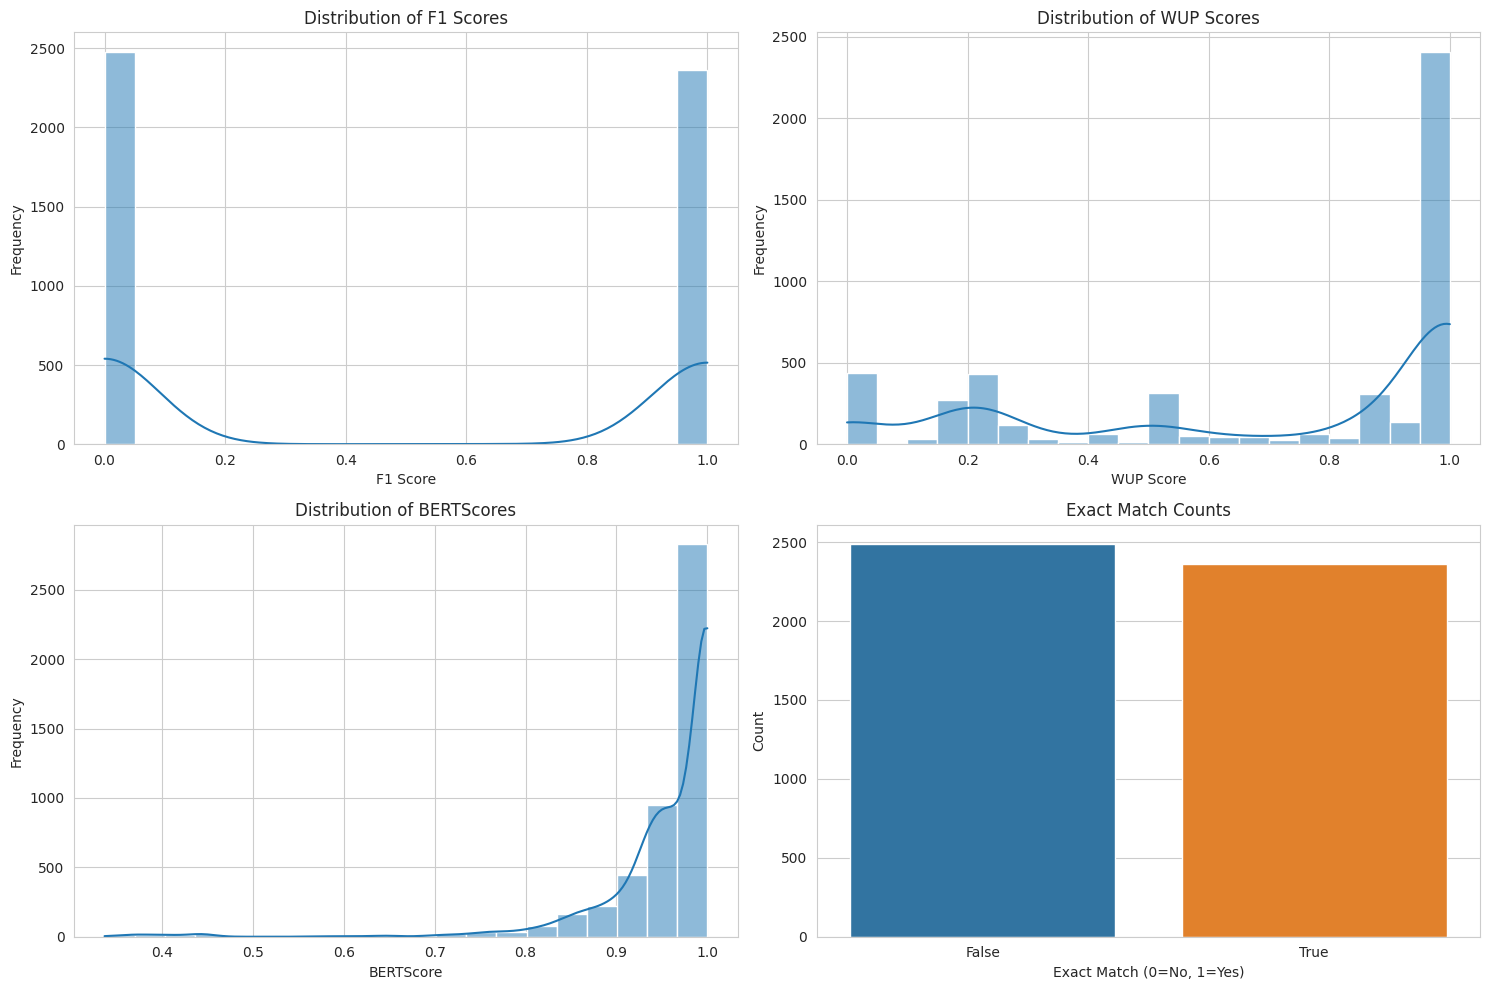

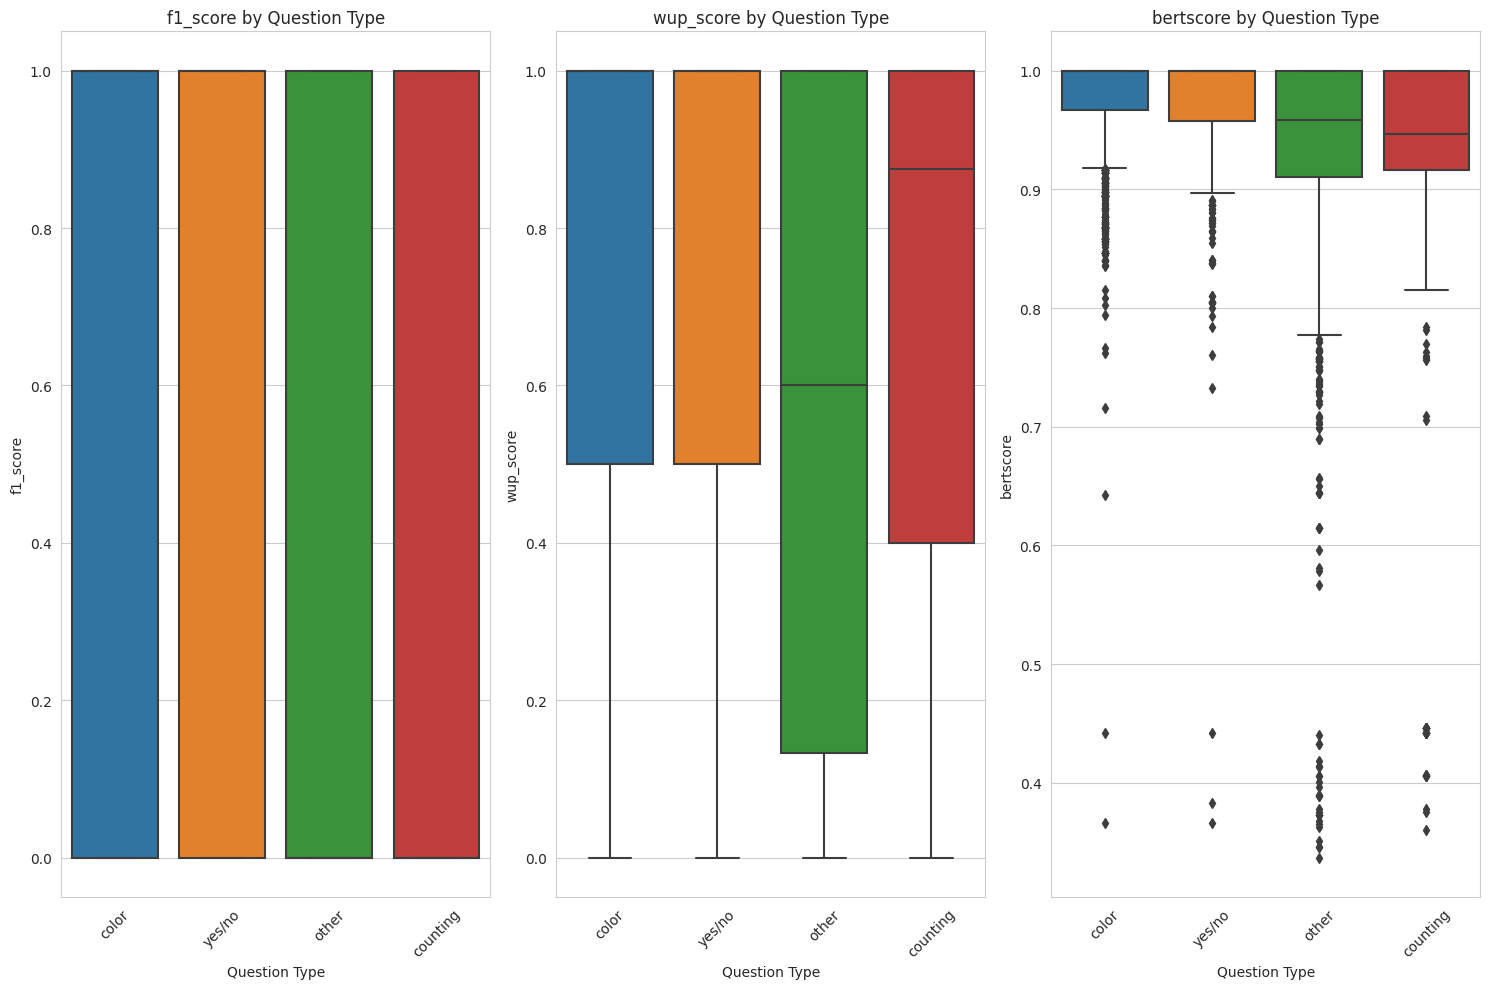

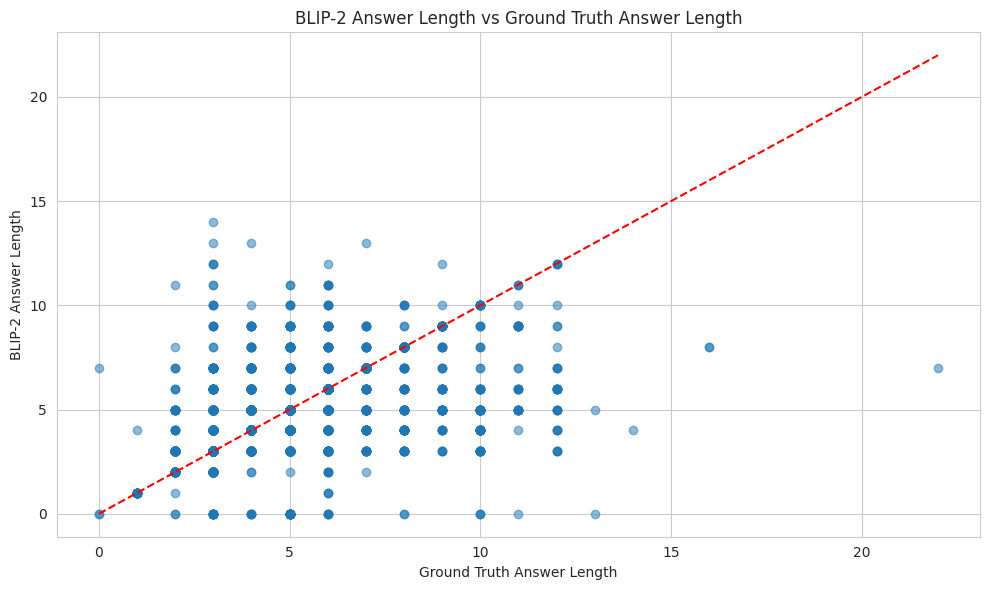

In [ ]:
if __name__ == "__main__":
    print("Starting VQA inference and evaluation process with BLIP-2...")
    results = run_inference()
    metrics = evaluate_results(results)
    error_analysis = run_error_analysis(results)
    visualize_metrics(results)  # Optional visualization
    print(f"\nResults saved to {OUTPUT_RESULTS_FILE}")
    print(f"Detailed metrics saved to {OUTPUT_METRICS_FILE}")